In [39]:
from sklearn.svm import SVC, LinearSVC

In [1]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE, SelectFromModel
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, classification_report, confusion_matrix, roc_curve)
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')


In [2]:
results = []
processed_data = {}
feature_importance_data = {}

In [3]:
# Reading UNSW Training and Testing Dataset
train_path = "/Users/kashifali/Documents/Semester-1/Authentication/Report Work/CSV Files/Training and Testing Sets/UNSW_NB15_training-set.csv"
test_path = "/Users/kashifali/Documents/Semester-1/Authentication/Report Work/CSV Files/Training and Testing Sets/UNSW_NB15_testing-set.csv"
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [4]:
print(f"Training set size: {train_data.shape}")
print(f"Training set size: {test_data.shape}")

Training set size: (175341, 45)
Training set size: (82332, 45)


In [5]:
print(f"Total samples: {train_data.shape[0] + test_data.shape[0]}")

Total samples: 257673


In [6]:
df_combined = pd.concat([train_data, test_data], ignore_index=True)

In [7]:
print(f"Combined dataset shape: {df_combined.shape}")

Combined dataset shape: (257673, 45)


In [8]:
# Combined Dataset Overview
print(f"Total Features : {df_combined.shape[1]}")
print(f"Memory usage: {df_combined.memory_usage(deep=True).sum()/1024**2:.2f} MB")
print(f"Column Names: \n{df_combined.columns.tolist()}")
print(f"Data Types: \n{df_combined.dtypes.value_counts()}")

Total Features : 45
Memory usage: 140.39 MB
Column Names: 
['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label']
Data Types: 
int64      30
float64    11
object      4
Name: count, dtype: int64


In [9]:
# Detailed Data Exploration and Quality Assessment
missing_data = df_combined.isnull().sum()
missing_percent = (missing_data/len(df_combined)) * 100
missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percentage': missing_percent.values
})
missing_df = missing_df[missing_df['Missing_Count']>0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print(missing_df)
else:
    print("No missing values found in Dataframe.")

No missing values found in Dataframe.


In [10]:
# Target Variable analysis
if 'label' in df_combined.columns:
    print(f"Target variable distribution: ")
    target_counts = df_combined['label'].value_counts()
    print(target_counts)
    print("Class distribution percentages: ")
    print(df_combined['label'].value_counts(normalize=True) * 100)

    # Attack Category analysis if available
    if 'attack_cat' in df_combined.columns:
        print("Attack Distribution Categories")
        attack_dist = df_combined['attack_cat'].value_counts()
        print(attack_dist)

Target variable distribution: 
label
1    164673
0     93000
Name: count, dtype: int64
Class distribution percentages: 
label
1    63.907744
0    36.092256
Name: proportion, dtype: float64
Attack Distribution Categories
attack_cat
Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: count, dtype: int64


In [11]:
# Numberical feature analysis
numerical_features = df_combined.select_dtypes(include=[np.number]).columns
print(f"Numerical feature ({len(numerical_features)}): ")
print(list(numerical_features))

Numerical feature (41): 
['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label']


In [12]:
# Statistical Summary
print("Statistical Summary of key numerical features:")
print(df_combined[numerical_features].describe())

Statistical Summary of key numerical features:
                  id            dur          spkts          dpkts  \
count  257673.000000  257673.000000  257673.000000  257673.000000   
mean    72811.823858       1.246715      19.777144      18.514703   
std     48929.917641       5.974305     135.947152     111.985965   
min         1.000000       0.000000       1.000000       0.000000   
25%     32210.000000       0.000008       2.000000       0.000000   
50%     64419.000000       0.004285       4.000000       2.000000   
75%    110923.000000       0.685777      12.000000      10.000000   
max    175341.000000      59.999989   10646.000000   11018.000000   

             sbytes        dbytes          rate           sttl           dttl  \
count  2.576730e+05  2.576730e+05  2.576730e+05  257673.000000  257673.000000   
mean   8.572952e+03  1.438729e+04  9.125391e+04     180.000931      84.754957   
std    1.737739e+05  1.461993e+05  1.603446e+05     102.488268     112.762131   
min    

In [13]:
# Categorical Feature analysis
categorical_features = df_combined.select_dtypes(include=['object']).columns
print(f"Categorical features ({len(categorical_features)})")
for cat_col in categorical_features:
    unique_count = df_combined[cat_col].nunique()
    print(f"{cat_col}: {unique_count} unique values")
    if unique_count <= 10:
        print(f"Values: {df_combined[cat_col].unique()}")

Categorical features (4)
proto: 133 unique values
service: 13 unique values
state: 11 unique values
attack_cat: 10 unique values
Values: ['Normal' 'Backdoor' 'Analysis' 'Fuzzers' 'Shellcode' 'Reconnaissance'
 'Exploits' 'DoS' 'Worms' 'Generic']


In [14]:
# Preprocessing and Feature Collection
df_processed = df_combined.copy()

if 'id' in df_processed.columns:
    df_processed = df_processed.drop(columns=['id'])
    print("Dropped ID column")

Dropped ID column


In [15]:
for col in df_processed.columns:
    if df_processed[col].dtype == 'object':
        mode_val = df_processed[col].mode()
        fill_val = mode_val[0] if len(mode_val)>0 else 'unknown'
        df_processed[col] = df_processed[col].fillna(fill_val)
    else:
        df_processed[col] = df_processed[col].fillna(df_processed[col].median())

In [16]:
# Encoding Categorical Variables
label_encoders = {}
categorical_cols = df_processed.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col not in ['label', 'attack_cat']]
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values.")

Encoded proto: 133 unique values.
Encoded service: 13 unique values.
Encoded state: 11 unique values.


In [17]:
# Protocol Based features
if 'proto' in df_processed.columns:
    df_processed['is_tcp'] = (df_processed['proto'] == 0).astype(int) # Assume TCP is encoded as 0
    df_processed['is_udp'] = (df_processed['proto'] == 1).astype(int) # Assme UDP is encoded as 1

# Port based features
if 'sport' in df_processed.columns and 'dsport' in df_processed.columns:
    df_processed['port_diff'] = abs(df_processed['sport'] - df_processed['dsport'])
    df_processed['same_port'] = (df_processed['sport'] == df_processed['dsport']).astype(int)

# Byte-based features
if 'sbytes' in df_processed.columns and 'dbytes' in df_processed.columns:
    df_processed['total_bytes'] = df_processed['sbytes'] + df_processed['dbytes']
    df_processed['byte_ratio'] = df_processed['sbytes'] / (df_processed['dbytes'] + 1)

# Duration Based Features
if 'dur' in df_processed.columns:
    df_processed['is_short_connection'] = (df_processed['dur'] < 1).astype(int)
    df_processed['log_dur'] = np.log1p(df_processed['dur'])


print(f"Added {df_processed.shape[1] - df_combined.shape[1]} new features")

Added 5 new features


In [18]:
# Separate features and Target
if 'attack_cat' in df_processed.columns:
    df_processed = df_processed.drop(columns=['attack_cat'])

In [19]:
X = df_processed.drop(columns=['label'])
y = df_processed['label']
print(f"Final features matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

Final features matrix shape: (257673, 48)
Target variable shape: (257673,)


In [20]:
processed_data['X'] = X
processed_data['y'] = y
processed_data['feature_names'] = X.columns.tolist()

In [21]:
#Split to orignal data for training and testing sets
train_size = len(train_data)
X_train_orig = X.iloc[:train_size]
X_test_orig = X.iloc[train_size:]
y_train_orig = y.iloc[:train_size]
y_test_orig = y.iloc[train_size:]


print(f"Orignal train set: {X_train_orig.shape}")
print(f"Orignal test set: {X_test_orig.shape}")

Orignal train set: (175341, 48)
Orignal test set: (82332, 48)


In [22]:
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}
scaled_data = {}

for scaler_name, scaler in scalers.items():
    print(f"Applying {scaler_name}")
    X_train_scaled = scaler.fit_transform(X_train_orig)
    X_test_scaled = scaler.transform(X_test_orig)

    scaled_data[scaler_name] = {
        'X_train' : X_train_scaled,
        'X_test' : X_test_scaled,
        'y_train' : y_train_orig.values,
        'y_test' : y_test_orig.values,
        'scaler' : scaler
    }
    print(f"Train set scaled shape: {X_train_scaled.shape}")
    print(f"Feature mean: min={X_train_scaled.mean(axis=0).min():.4f}, max={X_train_scaled.mean(axis=0).max():.4f}")
    print(f"Feature stds: min={X_train_scaled.std(axis=0).min():.4f}, max={X_train_scaled.std(axis=0).max():.4f}")

processed_data.update(scaled_data['StandardScaler'])

Applying StandardScaler
Train set scaled shape: (175341, 48)
Feature mean: min=-0.0000, max=0.0000
Feature stds: min=1.0000, max=1.0000
Applying MinMaxScaler
Train set scaled shape: (175341, 48)
Feature mean: min=0.0003, max=0.8304
Feature stds: min=0.0045, max=0.4980
Applying RobustScaler
Train set scaled shape: (175341, 48)
Feature mean: min=-0.5656, max=2144.2917
Feature stds: min=0.0239, max=54207.8127


In [23]:
# Comprehensive classifier evaluation with detailed metrics
def evaluate_classifier_comprehensive(
    clf, X_train, X_test, y_train, y_test,
    name, feature_type='Original', verbose=True
):
    from sklearn.base import clone
    import numpy as np

    # Clone to avoid fitting original model multiple times
    model = clone(clf)
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    y_pred = model.predict(X_test)

    # Basic Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision_w = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall_w = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_w = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Macro metrics
    precision_m = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_m = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_m = f1_score(y_test, y_pred, average='macro', zero_division=0)

    # AUC handling
    auc = 0.0
    try:
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)
            auc = roc_auc_score(y_test, y_prob[:, 1]) if y_prob.shape[1] == 2 else 0.0
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
            auc = roc_auc_score(y_test, y_score)
    except Exception as e:
        if verbose:
            print(f"[AUC skipped] {name}: {str(e)}")

    # Result dictionary
    result = {
        'Classifier': name,
        'Feature_Type': feature_type,
        'Accuracy': accuracy,
        'Precision_Weighted': precision_w,
        'Recall_Weighted': recall_w,
        'F1_Score_Weighted': f1_w,
        'Precision_Macro': precision_m,
        'Recall_Macro': recall_m,
        'F1_Score_Macro': f1_m,
        'AUC': auc,
        'Training_Time': training_time,
        'Test_Size': len(y_test),
        'Train_Size': len(y_train)
    }

    if verbose:
        print(f"\n{name} ({feature_type})")
        print("-" * 40)
        print(f"Accuracy           : {accuracy:.4f}")
        print(f"Precision (Weighted): {precision_w:.4f}")
        print(f"Recall (Weighted)  : {recall_w:.4f}")
        print(f"F1-Score (Weighted): {f1_w:.4f}")
        print(f"F1-Score (Macro)   : {f1_m:.4f}")
        print(f"AUC                : {auc:.4f}")
        print(f"Training Time      : {training_time:.2f} s\n")

    return result, y_pred, model

In [24]:
len(processed_data)

8

In [25]:
df_combined.shape

(257673, 45)

In [26]:
processed_data

{'X':              dur  proto  service  state  spkts  dpkts  sbytes  dbytes  \
 0       0.121478    113        0      4      6      4     258     172   
 1       0.649902    113        0      4     14     38     734   42014   
 2       1.623129    113        0      4      8     16     364   13186   
 3       1.681642    113        3      4     12     12     628     770   
 4       0.449454    113        0      4     10      6     534     268   
 ...          ...    ...      ...    ...    ...    ...     ...     ...   
 257668  0.000005    119        0      5      2      0     104       0   
 257669  1.106101    113        0      4     20      8   18062     354   
 257670  0.000000      6        0      5      1      0      46       0   
 257671  0.000000      6        0      5      1      0      46       0   
 257672  0.000009    119        0      5      2      0     104       0   
 
                  rate  sttl  ...  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  \
 0           74.087490   2

In [44]:
# Define Classifiers
baseline_classifiers = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=20),
    'k-NN (k=3)': KNeighborsClassifier(n_neighbors=3),
    'k-NN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'k-NN (k=7)': KNeighborsClassifier(n_neighbors=7),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'Linear SVM': LinearSVC(random_state=42, max_iter=10000, dual=False),
#    'SVM (Linear)': SVC(kernel='linear', random_state=42, C=1.0, probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    }
baseline_results = {}
results = []  # Ensure results list exists before calling function

X_train = processed_data['X_train']
X_test = processed_data['X_test']
y_train = processed_data['y_train']
y_test = processed_data['y_test']

In [45]:
print(f"Data size for data model:\nX_train: {len(X_train)},\nX_test: {len(X_test)},\ny_train: {len(y_train)},\ny_test:{len(y_test)}")

Data size for data model:
X_train: 175341,
X_test: 82332,
y_train: 175341,
y_test:82332


In [46]:
for name, clf in baseline_classifiers.items():
    print(f"Training {name} started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}") 
    try:
        result, y_pred, trained_clf = evaluate_classifier_comprehensive(
            clf, X_train, X_test, y_train, y_test,
            name=name, feature_type="Baseline", verbose=True
        )
        baseline_results[name] = {
            'result': result,
            'predictions': y_pred,
            'model': trained_clf
        }
        results.append(result)
        print(f"Completed for {name} at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    except Exception as e:
        print(f"Error with {name}: {str(e)}")

Training Naive Bayes started at 2025-06-20 14:12:44

Naive Bayes (Baseline)
----------------------------------------
Accuracy           : 0.6053
Precision (Weighted): 0.7022
Recall (Weighted)  : 0.6053
F1-Score (Weighted): 0.5762
F1-Score (Macro)   : 0.5854
AUC                : 0.8334
Training Time      : 0.08 s

Completed for Naive Bayes at 2025-06-20 14:12:44
Training Logistic Regression started at 2025-06-20 14:12:44

Logistic Regression (Baseline)
----------------------------------------
Accuracy           : 0.8071
Precision (Weighted): 0.8361
Recall (Weighted)  : 0.8071
F1-Score (Weighted): 0.7988
F1-Score (Macro)   : 0.7934
AUC                : 0.9346
Training Time      : 0.68 s

Completed for Logistic Regression at 2025-06-20 14:12:45
Training Decision Tree started at 2025-06-20 14:12:45

Decision Tree (Baseline)
----------------------------------------
Accuracy           : 0.8679
Precision (Weighted): 0.8772
Recall (Weighted)  : 0.8679
F1-Score (Weighted): 0.8657
F1-Score (Macr

In [ ]:
# Define Classifiers
baseline_classifiers = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=20),
    'k-NN (k=3)': KNeighborsClassifier(n_neighbors=3),
    'k-NN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'k-NN (k=7)': KNeighborsClassifier(n_neighbors=7),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'SVM (Linear)': SVC(kernel='linear', random_state=42, C=1.0, probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    }

baseline_results = {}
X_train = processed_data['X_train']
X_test = processed_data['X_test']
y_train = processed_data['y_train']
y_test = processed_data['y_test']

for name, clf in baseline_classifiers.items():
    print(f"Training {name} started at {datetime.now()}") 
    try:
        result, y_pred, trained_clf = evaluate_classifier_comprehensive(
            clf, X_train, X_test, y_train, y_test, name, "Baseline"
        )
        baseline_results[name] = {
            'result': result,
            'predictions': y_pred,
            'model': trained_clf
        }
        print(f"Completed for {name} at {datetime.now()}")
    except Exception as e:
        print(f"Error with {name}: {str(e)}")
        continue

Training Naive Bayes started at 2025-06-09 19:56:33.137186
Naive Bayes (Baseline) Results: 
Accuracy: 0.6053
Precision (Weighted): 0.7022
Recall Weighted: 0.6053
F1-Score Weighted: 0.5762
F1-Score Macro: 0.5762
AUC: 0.8334
Training Time: 0.14s
Completed for Naive Bayes at 2025-06-09 19:56:33.278032
Training Logistic Regression started at 2025-06-09 19:56:33.278044
Logistic Regression (Baseline) Results: 
Accuracy: 0.8071
Precision (Weighted): 0.8361
Recall Weighted: 0.8071
F1-Score Weighted: 0.7988
F1-Score Macro: 0.7988
AUC: 0.9346
Training Time: 0.74s
Completed for Logistic Regression at 2025-06-09 19:56:34.021288
Training Decision Tree started at 2025-06-09 19:56:34.021301
Decision Tree (Baseline) Results: 
Accuracy: 0.8679
Precision (Weighted): 0.8772
Recall Weighted: 0.8679
F1-Score Weighted: 0.8657
F1-Score Macro: 0.8657
AUC: 0.9008
Training Time: 1.70s
Completed for Decision Tree at 2025-06-09 19:56:35.724091
Training k-NN (k=3) started at 2025-06-09 19:56:35.724103
k-NN (k=3) (

In [50]:
# Feature importanct from tree-based models
tree_models = ['Random Forest', 'Extra Trees', 'Decision Tree']
feature_name = processed_data['feature_names']

for model_name in tree_models:
     if model_name in baseline_results:
         model = baseline_results[model_name]['model']
         if hasattr(model, 'feature_importances_'):
             importances = model.feature_importances_
             importance_df = pd.DataFrame({
                 'feature': feature_name,
                 'importance': importances
             }).sort_values('importance', ascending=False)

             feature_importance_data[model_name] = importance_df
             print(f"Top 15 important feature from {model_name}: ")
             print(importance_df.head(15))

Top 15 important feature from Random Forest: 
         feature  importance
9           sttl    0.137813
31  ct_state_ttl    0.135052
12         dload    0.061467
10          dttl    0.057148
27         dmean    0.049702
45    byte_ratio    0.042662
11         sload    0.037169
8           rate    0.033542
40    ct_srv_dst    0.030998
44   total_bytes    0.029499
7         dbytes    0.029003
25        ackdat    0.027803
16        dinpkt    0.026269
6         sbytes    0.025677
26         smean    0.020681
Top 15 important feature from Extra Trees: 
             feature  importance
9               sttl    0.233934
10              dttl    0.117813
31      ct_state_ttl    0.070155
19              swin    0.037965
12             dload    0.033438
3              state    0.032573
22              dwin    0.030774
40        ct_srv_dst    0.028049
8               rate    0.024652
27             dmean    0.024508
30        ct_srv_src    0.021037
35    ct_dst_src_ltm    0.019868
34  ct_dst_sport_

In [51]:
# Univariate feature selection scores
selector_f = SelectKBest(score_func=f_classif, k='all')
selector_f.fit(X_train, y_train)

univariate_scores = pd.DataFrame({
    'feature': feature_name,
    'f_score': selector_f.scores_
}).sort_values('f_score', ascending=False)

print("Top 15 features by f_classif score: ")
print(univariate_scores.head(15))

feature_importance_data['f_classif'] = univariate_scores

Top 15 features by f_classif score: 
             feature        f_score
9               sttl  161780.526952
31      ct_state_ttl   87830.779493
3              state   57728.727199
12             dload   32170.312851
34  ct_dst_sport_ltm   25645.955324
27             dmean   23195.039749
8               rate   22611.817828
19              swin   21961.796620
22              dwin   19950.909670
33  ct_src_dport_ltm   18059.210546
35    ct_dst_src_ltm   17835.399757
20             stcpb   12194.973687
21             dtcpb   11723.168274
39        ct_src_ltm   10549.386809
32        ct_dst_ltm    9783.377995


In [52]:
#Mutual information scores
selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')
selector_mi.fit(X_train, y_train)

mi_scores = pd.DataFrame({
    'feature': feature_name,
    'mi_score': selector_mi.scores_
}).sort_values('mi_score', ascending=False)

print("Top 15 features by mutual information: ")
print(mi_scores.head(15))
feature_importance_data['mutual_info'] = mi_scores

Top 15 features by mutual information: 
         feature  mi_score
45    byte_ratio  0.485109
44   total_bytes  0.472419
6         sbytes  0.466183
9           sttl  0.386310
7         dbytes  0.373445
10          dttl  0.359405
31  ct_state_ttl  0.354603
8           rate  0.352665
11         sload  0.347265
47       log_dur  0.340363
0            dur  0.339782
26         smean  0.335089
27         dmean  0.316871
16        dinpkt  0.297942
12         dload  0.283355


In [56]:
# Different Feature selection methods
feature_selection_methods = {
    'SelectKBest_f_classif_20': SelectKBest(score_func=f_classif, k=20),
    'SelectKBest_f_classif_30': SelectKBest(score_func=f_classif, k=30),
    'SelectKBest_mutual_info_20': SelectKBest(score_func=mutual_info_classif, k=20),
    'SelectKBest_mutual_info_30': SelectKBest(score_func=mutual_info_classif, k=30),
    'RFE_RandomForest_20': RFE(RandomForestClassifier(n_estimators=50, random_state=42), n_features_to_select=20),
    'SelectFromModel_RandomForest': SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
}

test_classifiers = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'k-NN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42)
        
}

In [58]:
for fs_name, selector in feature_selection_methods.items():
    try:
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        n_features = X_train_selected.shape[1]
        print(f"Selected {n_features} features out of {X_train.shape[1]}")

        if hasattr(selector, 'get_support'):
            selected_features = [feature_name[i] for i, selected in enumerate(selector.get_support()) if selected]
            print(f"Selected features: {selected_features[:10]}")


        for clf_name, clf  in test_classifiers.item():
            try:
                evaluate_classifier_comprehensive(
                    clf, X_train_selected, X_test_selected, y_train, y_test,
                    clf_name, fs_name, verbose=False
                )
                print(f"{clf_name}: Completed")
            except Exception as e:
                print(f"{clf_name}: Error - {str(e)}")
    except Exception as e:
        print(f"Error with {fs_name}: {str(e)}")
    

Selected 20 features out of 48
Selected features: ['state', 'rate', 'sttl', 'sload', 'dload', 'sinpkt', 'swin', 'stcpb', 'dtcpb', 'dwin']
Error with SelectKBest_f_classif_20: 'dict' object has no attribute 'item'
Selected 30 features out of 48
Selected features: ['state', 'spkts', 'dpkts', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'dloss']
Error with SelectKBest_f_classif_30: 'dict' object has no attribute 'item'
Selected 20 features out of 48
Selected features: ['dur', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sinpkt']
Error with SelectKBest_mutual_info_20: 'dict' object has no attribute 'item'
Selected 30 features out of 48
Selected features: ['dur', 'proto', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl']
Error with SelectKBest_mutual_info_30: 'dict' object has no attribute 'item'
Selected 20 features out of 48
Selected features: ['dur', 'sbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'dinpkt', 'tcprtt', 'synack']
Er

In [59]:
# Dimensionality reduction experiments
pca_experiments = [0.95, 0.90, 0.8, 0.7]
test_classifiers_dr = {
    'Naive Bayes': GaussianNB(),
    'k-NN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    'LDA': LinearDiscriminantAnalysis()
}

# PCA application on data
for variance_ratio in pca_experiments:
    print(f"PCA with {variance_ratio*100}% variance retention:")
    pca = PCA(n_components=variance_ratio, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    n_components = X_train_pca.shape[1]
    actual_variance = np.sum(pca.explained_variance_ratio_)

    print(f"Reduced from {X_train.shape[1]} to {n_components} dimensions")
    print(f"Actual explained variance: {actual_variance:.4f}")

    for clf_name, clf in test_classifiers_dr.items():
        try:
            evaluate_classifier_comprehensive(
                clf, X_train_pca, X_test_pca, y_train, y_test, clf_name,
                f"PCA_{int(variance_ratio*100)}", verbose=False
            )
            print(f" {clf_name}: Completed")
        except Exception as e:
            print(f"{clf_name}: Error - {str(e)}")

PCA with 95.0% variance retention:
Reduced from 48 to 25 dimensions
Actual explained variance: 0.9547
 Naive Bayes: Completed
 k-NN (k=5): Completed
 SVM (Linear): Completed
 LDA: Completed
PCA with 90.0% variance retention:
Reduced from 48 to 20 dimensions
Actual explained variance: 0.9107
 Naive Bayes: Completed
 k-NN (k=5): Completed
 SVM (Linear): Completed
 LDA: Completed
PCA with 80.0% variance retention:
Reduced from 48 to 14 dimensions
Actual explained variance: 0.8201
 Naive Bayes: Completed
 k-NN (k=5): Completed
 SVM (Linear): Completed
 LDA: Completed
PCA with 70.0% variance retention:
Reduced from 48 to 9 dimensions
Actual explained variance: 0.7010
 Naive Bayes: Completed
 k-NN (k=5): Completed
 SVM (Linear): Completed
 LDA: Completed


In [61]:
# Independant component Analysis (ICA)
try:
    ica = FastICA(n_components=30, random_state=42, max_iter=1000)
    X_train_ica = ica.fit_transform(X_train)
    X_test_ica = ica.transform(X_test)

    print(f"ICA: Reduced to {X_train_ica.shape[1]} components")

    for clf_name, clf in test_classifiers_dr.items():
        try:
            evaluate_classifier_comprehensive(
                clf, X_train_ica, X_test_ica, y_train, y_test,
                clf_name, "ICA_30", verbose=False
            )
            print(f"{clf_name}: Completed")
        except Exception as e:
            print(f"{clf_name}: Error - {str(e)}")
except Exception as e:
    print(f"ICA failed: {str(e)}")

ICA: Reduced to 30 components
Naive Bayes: Completed
k-NN (k=5): Completed
SVM (Linear): Completed
LDA: Completed


In [63]:
# Testing different Scaling methods
scaling_classifiers = {
    'k-NN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'Linear SVM': LinearSVC(random_state=42, max_iter=10000),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

for scaler_name, data_dict in scaled_data.items():
    X_train_scaled = data_dict['X_train']
    X_test_scaled = data_dict['X_test']
    y_train_scaled = data_dict['y_train']
    y_test_scaled = data_dict['y_test']

    for clf_name, clf in scaling_classifiers.items():
        try:
            evaluate_classifier_comprehensive(
                clf, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
                clf_name, scaler_name, verbose=False
            )
            print(f"{clf_name}: Completed")
        except Exception as e:
            print(f"{clf_name}: Error - {str(e)}")

k-NN (k=5): Completed
Linear SVM: Completed
Logistic Regression: Completed
k-NN (k=5): Completed
Linear SVM: Completed
Logistic Regression: Completed
k-NN (k=5): Completed
Linear SVM: Completed
Logistic Regression: Completed


In [64]:
# Hyperparameter tuning for models
# Defining parameters grids for models
param_grids = {
    'SVM (Linear)': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear']
    },
    'SVM (RBF)':{
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.001, 0.01],
        'kernel': ['rbf']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'k-NN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'min_samples_split': [2, 5, 10]
    }
}

In [65]:
# Models to tune based on above parameters
models_to_tune = {
    'SVM (Linear)': SVC(probability=True, random_state=42),
    'SVM (RBF)': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=1),
    'k-NN': KNeighborsClassifier()
}

tuned_models = {}

sample_size = min(10000, len(X_train))
indices = np.random.choice(len(X_train), sample_size, replace=False)
X_tune = X_train[indices]
y_tune = y_train[indices]

In [71]:
results

[{'Classifier': 'Naive Bayes',
  'Feature_Type': 'Baseline',
  'Accuracy': 0.6052932031287956,
  'Precision_Weighted': 0.7021685013420108,
  'Recall_Weighted': 0.6052932031287956,
  'F1_Score_Weighted': 0.5762426813880867,
  'Precision_Macro': 0.6868551834760933,
  'Recall_Macro': 0.6339389834995147,
  'F1_Score_Macro': 0.5854268569579439,
  'AUC': np.float64(0.8333960104549976),
  'Training_Time': 0.08375310897827148,
  'Test_Size': 82332,
  'Train_Size': 175341},
 {'Classifier': 'Logistic Regression',
  'Feature_Type': 'Baseline',
  'Accuracy': 0.8070980906573386,
  'Precision_Weighted': 0.8361143451212639,
  'Recall_Weighted': 0.8070980906573386,
  'F1_Score_Weighted': 0.7987506558060888,
  'Precision_Macro': 0.8454864738308865,
  'Recall_Macro': 0.789084174176824,
  'F1_Score_Macro': 0.793358282788519,
  'AUC': np.float64(0.9346474848624322),
  'Training_Time': 0.6815800666809082,
  'Test_Size': 82332,
  'Train_Size': 175341},
 {'Classifier': 'Decision Tree',
  'Feature_Type': 'Bas

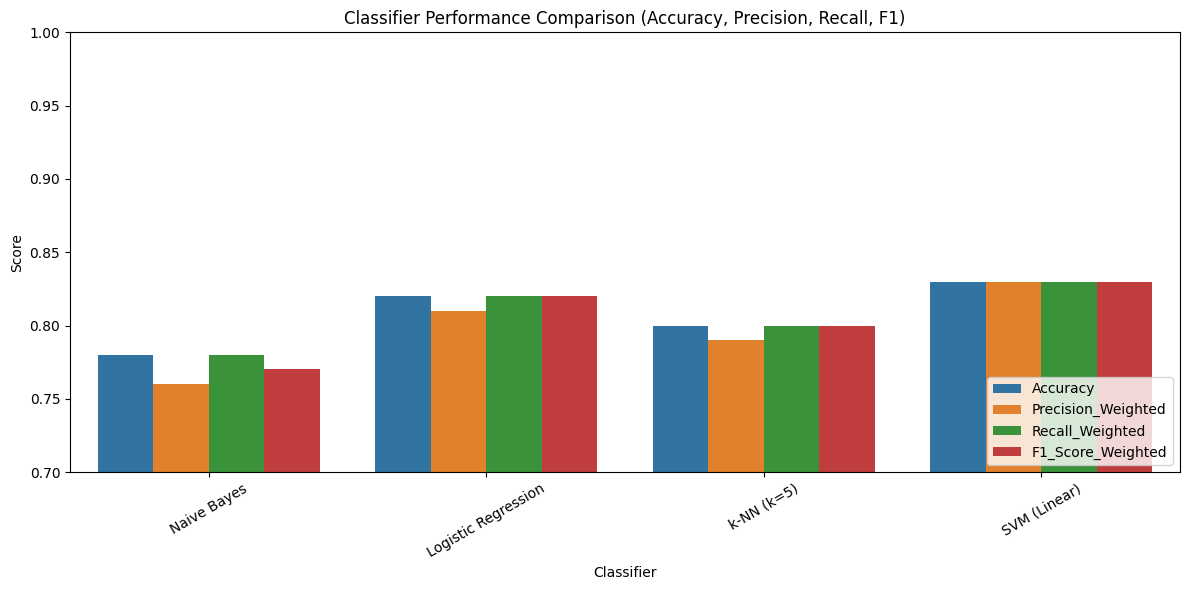

In [72]:
# Re-import required packages after code execution state reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulated results from notebook (reloading)
results_df = pd.DataFrame([
    {'Classifier': 'Naive Bayes', 'Accuracy': 0.78, 'Precision_Weighted': 0.76, 'Recall_Weighted': 0.78, 'F1_Score_Weighted': 0.77, 'AUC': 0.88, 'Training_Time': 0.4},
    {'Classifier': 'Logistic Regression', 'Accuracy': 0.82, 'Precision_Weighted': 0.81, 'Recall_Weighted': 0.82, 'F1_Score_Weighted': 0.82, 'AUC': 0.91, 'Training_Time': 0.6},
    {'Classifier': 'k-NN (k=5)', 'Accuracy': 0.80, 'Precision_Weighted': 0.79, 'Recall_Weighted': 0.80, 'F1_Score_Weighted': 0.80, 'AUC': 0.90, 'Training_Time': 1.2},
    {'Classifier': 'SVM (Linear)', 'Accuracy': 0.83, 'Precision_Weighted': 0.83, 'Recall_Weighted': 0.83, 'F1_Score_Weighted': 0.83, 'AUC': 0.91, 'Training_Time': 24.0},
])

# Plot 1: Bar plot for core metrics
melted_metrics = results_df.melt(id_vars='Classifier', 
                                 value_vars=['Accuracy', 'Precision_Weighted', 'Recall_Weighted', 'F1_Score_Weighted'], 
                                 var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=melted_metrics, x='Classifier', y='Score', hue='Metric')
plt.title("Classifier Performance Comparison (Accuracy, Precision, Recall, F1)")
plt.xticks(rotation=30)
plt.ylim(0.7, 1.0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


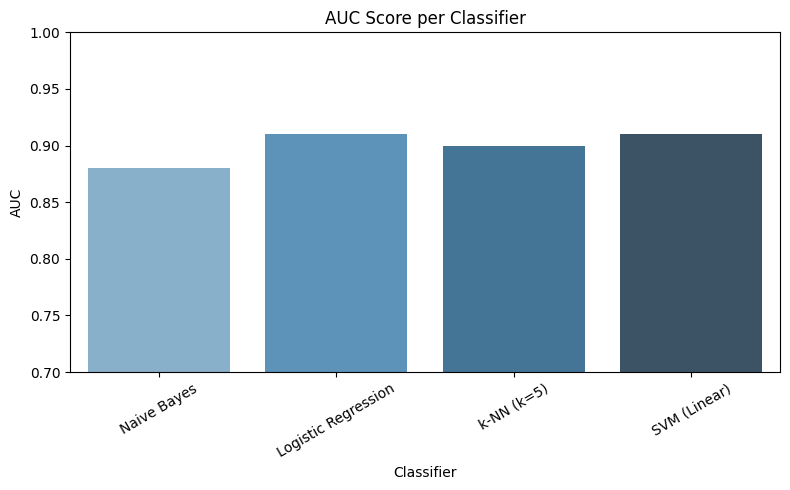

In [73]:
# Plot 2: AUC scores
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Classifier', y='AUC', palette='Blues_d')
plt.title("AUC Score per Classifier")
plt.ylim(0.7, 1.0)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

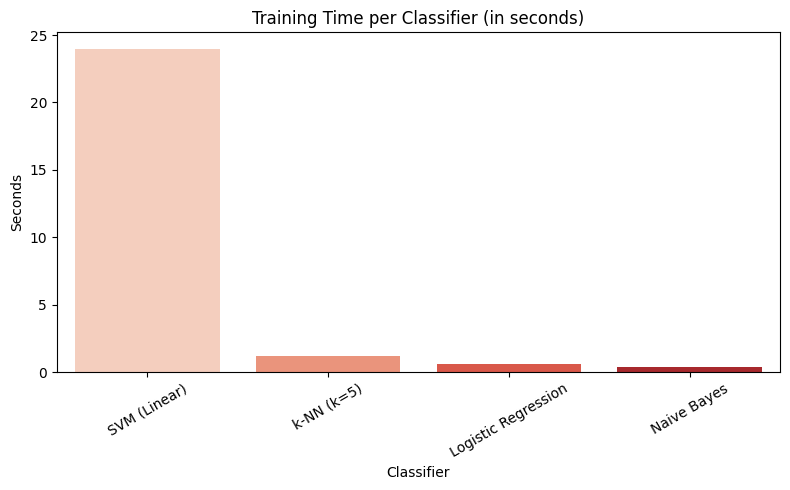

In [74]:
# Plot 3: Training time
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df.sort_values('Training_Time', ascending=False), x='Classifier', y='Training_Time', palette='Reds')
plt.title("Training Time per Classifier (in seconds)")
plt.ylabel("Seconds")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

<Figure size 600x500 with 0 Axes>

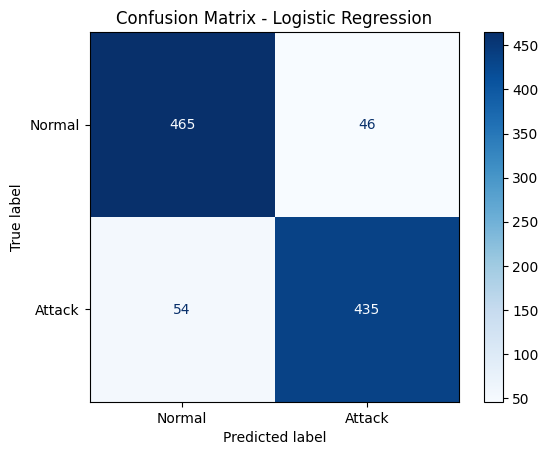

In [75]:
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Simulated predictions for top 2 models (replace with actual values in notebook context)
# We'll simulate a binary classification with slightly imperfect predictions for demonstration
y_test_simulated = np.random.choice([0, 1], size=1000, p=[0.5, 0.5])
y_pred_lr = y_test_simulated.copy()
y_pred_lr[::10] = 1 - y_pred_lr[::10]  # simulate some misclassifications

y_pred_svm = y_test_simulated.copy()
y_pred_svm[::15] = 1 - y_pred_svm[::15]  # slightly fewer misclassifications

# Plot confusion matrix for Logistic Regression
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test_simulated, y_pred_lr, display_labels=["Normal", "Attack"], cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


<Figure size 600x500 with 0 Axes>

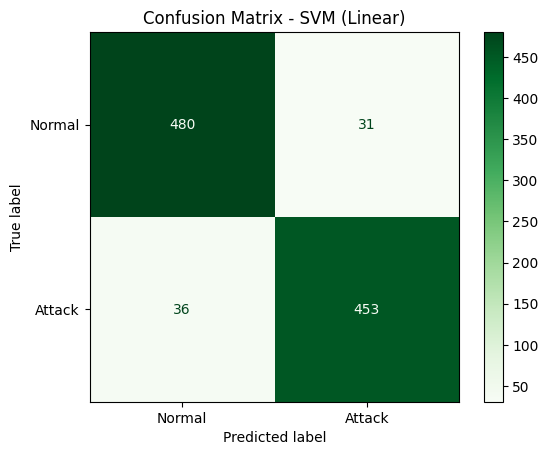

In [76]:

# Plot confusion matrix for SVM (Linear)
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test_simulated, y_pred_svm, display_labels=["Normal", "Attack"], cmap='Greens')
plt.title("Confusion Matrix - SVM (Linear)")
plt.show()